<a href="https://colab.research.google.com/github/iu5git/Deep-learning/blob/main/homework/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 1

## Импортирование необходимых библиотек

In [ ]:
from PIL import Image
from glob import glob
import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms as T
from tensorflow import summary as tfsummary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

## Чтение тренировочной и тестовой выборки

Инструкция для скачивания и загрузки фотографий в Сolab находится в github

In [ ]:
heigth_width = 32

CLASSES = ['Торт', 'Ласточка', 'Кошка'] # Здесь требуется указать ваши классы

images = []
images_t = []
classes = []
classes_t = []

for CLASS in range(0, len(CLASSES)):
  path_class_1 = "/content/%s/*.*"%CLASSES[CLASS]
  i=0
  for photo in glob(path_class_1):
      i+=1
      img = Image.open(photo).convert('RGB')
      img = img.resize((heigth_width, heigth_width), Image.ANTIALIAS)
      if i > int(len(os.listdir("/content/%s/"%CLASSES[CLASS]))*0.8):
          images_t.append(np.asarray(img))
          classes_t.append(np.asarray(CLASS))
      else:
          images.append(np.asarray(img))
          classes.append(np.asarray(CLASS))

    
train_X = np.array(images)
train_y = np.array(classes)

test_X = np.array(images_t)
test_y = np.array(classes_t)

###Приведение фотографий к требуемому размеру

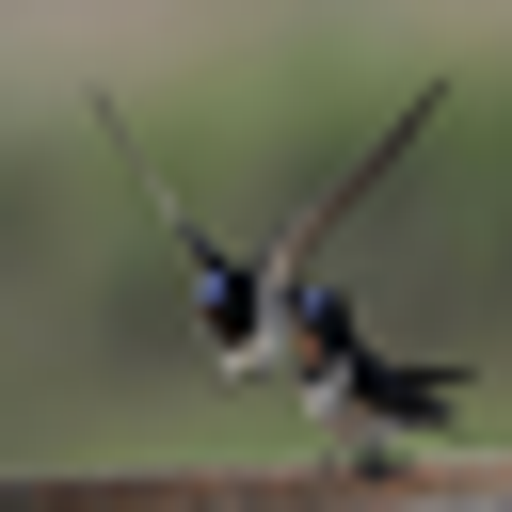

In [ ]:
Image.fromarray(train_X[123]).resize((512,512))

##Создание Pytorch DataLoader'a

In [ ]:
batch_size = 32
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fc87c104c10>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fc87c104850>}

##Создание Pytorch модели многослойного перцептрона с одним скрытым слоем

In [ ]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

HIDDEN_SIZE = 10
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

##Выбор функции потерь и оптимизатора градиентного спуска

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

##Обучение модели по эпохам

In [ ]:
EPOCHS = 250
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    running_loss = 0.0
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение закончено')

[1,     8] loss: 1.045
[1,     2] val loss: 0.941
[2,     8] loss: 0.923
[2,     2] val loss: 0.880
[3,     8] loss: 0.851
[3,     2] val loss: 0.786
[4,     8] loss: 0.805
[4,     2] val loss: 0.765
[5,     8] loss: 0.757
[5,     2] val loss: 0.726
[6,     8] loss: 0.736
[6,     2] val loss: 0.715
[7,     8] loss: 0.690
[7,     2] val loss: 0.698
[8,     8] loss: 0.679
[8,     2] val loss: 0.679
[9,     8] loss: 0.645
[9,     2] val loss: 0.659
[10,     8] loss: 0.615
[10,     2] val loss: 0.655
[11,     8] loss: 0.591
[11,     2] val loss: 0.658
[12,     8] loss: 0.559
[12,     2] val loss: 0.641
[13,     8] loss: 0.543
[13,     2] val loss: 0.637
[14,     8] loss: 0.529
[14,     2] val loss: 0.620
[15,     8] loss: 0.498
[15,     2] val loss: 0.605
[16,     8] loss: 0.488
[16,     2] val loss: 0.599
[17,     8] loss: 0.469
[17,     2] val loss: 0.595
[18,     8] loss: 0.448
[18,     2] val loss: 0.582
[19,     8] loss: 0.425
[19,     2] val loss: 0.587
[20,     8] loss: 0.424
[20,  

##Проверка качества модели по классам на обучающей и тестовой выборках

In [ ]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

        Торт     0.9756    1.0000    0.9877        80
    Ласточка     1.0000    0.9750    0.9873        80
       Кошка     1.0000    1.0000    1.0000        80

    accuracy                         0.9917       240
   macro avg     0.9919    0.9917    0.9917       240
weighted avg     0.9919    0.9917    0.9917       240

--------------------------------------------------
test
              precision    recall  f1-score   support

        Торт     0.8182    0.9000    0.8571        20
    Ласточка     0.8947    0.8947    0.8947        19
       Кошка     0.7647    0.6842    0.7222        19

    accuracy                         0.8276        58
   macro avg     0.8259    0.8263    0.8247        58
weighted avg     0.8257    0.8276    0.8253        58

--------------------------------------------------


##Сохранение модели в ONNX

In [ ]:
# сохраниение модели
# ПЕРВЫЙ СПОСОБ: сохранение параметров
PATH = 'cifar.pth'
torch.save(model.state_dict(), PATH)
# загрузка
new_model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
new_model.load_state_dict(torch.load(PATH))
new_model.eval()

# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar.pt'
torch.save(model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval()

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [ ]:
# входной тензор для модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})